# 0.0 - Imports and Load

In [1]:
import pandas as pd
import inflection
import numpy as np
import math
import seaborn as sns
import xgboost as xgb
import random
import pickle
import json
import requests

from matplotlib import pyplot as plt
from IPython.display import Image
from datetime import datetime, timedelta
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression, Lasso

/home/aderaldo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0.1 - Helper function

In [2]:
snakecase = lambda x: inflection.underscore(x) 

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model, y, y_hat ):
    mae = mt.mean_absolute_error( y, y_hat )
    mape = mean_absolute_percentage_error( y, y_hat )
    rmse = mt.mean_squared_error( y, y_hat, squared = False )
    return pd.DataFrame( {'Model' : model,
                           'Mae' : mae,
                           'Mape' : mape,
                           'RMSE' : rmse}, index = [0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
        mae_list = []
        mape_list = []
        rmse_list = []
        # O reversed é um função pra pegar os valores inversos
        for k in reversed( range( 1, kfold+1 ) ):
            if verbose:
                print( '\nKFold Number: {}'.format( k ) )
            # start and end date for validation
            validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
            validation_end_date = x_training['date'].max() - timedelta( days=(k-1)*6*7)
            # filtering dataset
            training = x_training[x_training['date'] < validation_start_date]
            validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
            # Agora que já tenho os dados filtrados, vou excluir as variaveis para fazer o treinamento
            # training
            xtraining = training.drop( ['date', 'sales'], axis=1 )
            ytraining = training['sales']
            # validation
            xvalidation = validation.drop( ['date', 'sales'], axis=1 )
            yvalidation = validation['sales']
            # model
            m = model.fit( xtraining, ytraining )
            # prediction
            yhat = m.predict( xvalidation )
            # performance
            m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
            # store performance of each kfold iteration
            mae_list.append( m_result['Mae'] )
            mape_list.append( m_result['Mape'] )
            rmse_list.append( m_result['RMSE'] )
        return pd.DataFrame( {'Model Name': model_name,
        'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )


## 0.2 - Load Dataset

In [3]:
df_raw_sales = pd.read_csv('/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/Data/train.csv', low_memory = False)

df_raw_store = pd.read_csv('/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/Data/store.csv', low_memory = False)

df_raw = pd.merge( df_raw_sales, df_raw_store, how = 'left', on = 'Store')

# 1.0 - Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 - Rename Columns

In [7]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

news_cols = list( map(snakecase, old_cols) )


In [7]:
df1.columns = news_cols

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Data Dimesion

In [9]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 - Data Types

In [8]:
df1["date"] = pd.to_datetime( df1["date"] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [9]:
df1.isna().sum()
# por que os NA estão nessas colunas?

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Fillout NA

In [9]:
# competition_distance
# É a distância entre os competidores
# subistitui os valores ausente pelo valor máximo encontrado nessa coluna;
max_valor = df1["competition_distance"].max()

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_valor if pd.isnull(x) else x)

# competition_open_since_month
# É um numero contendo o mês e ano que a loja competidora foi aberta
# A lógica para a subistituição vai ser a extração do valor do mês da coluna data;
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)

# competition_open_since_year
# A mesma lógica do exemplo anterior
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6 - Change Types

In [33]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                       object
promo_interval                          object
dtype: object

In [10]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int) 
df1["competition_open_since_year"] =  df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] =  df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] =  df1["promo2_since_year"].astype(int)
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6 - Description Statiscal

In [11]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

In [28]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval
521454,0,d,c,"Jan,Apr,Jul,Oct"
246836,0,d,c,"Jan,Apr,Jul,Oct"


In [62]:
# Central Tendency 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion Tendency

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max( ) - x.min( ) ) ). T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew( ) ) ). T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis( ) ) ). T

# Concat

m = pd.concat( [d3, d2, d4, ct1, ct2, d1, d5, d6] ).T
m.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ] 

In [63]:
m

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,75860.0,75840.0,5613.013481,2330.0,8498.334094,3.599472,19.780674
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


- uma skew próxima de zero e a kurtosis próxima de 1 indica que os dados estão normais.

/tmp/ipykernel_163958/1848217301.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1["sales"] )
/home/aderaldo/anaconda3/envs/DataScienceEmProducao/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sales', ylabel='Density'>

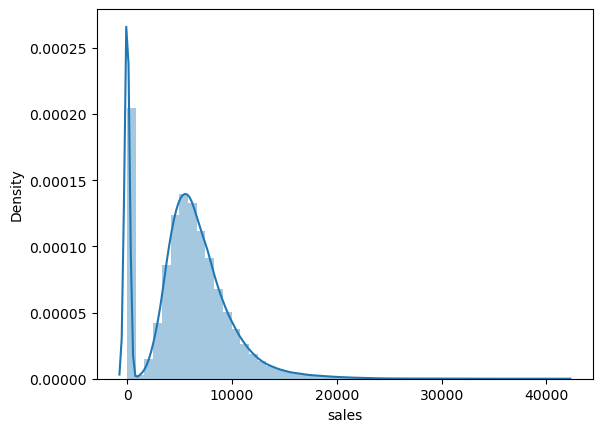

In [70]:
sns.distplot( df1["sales"] )

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

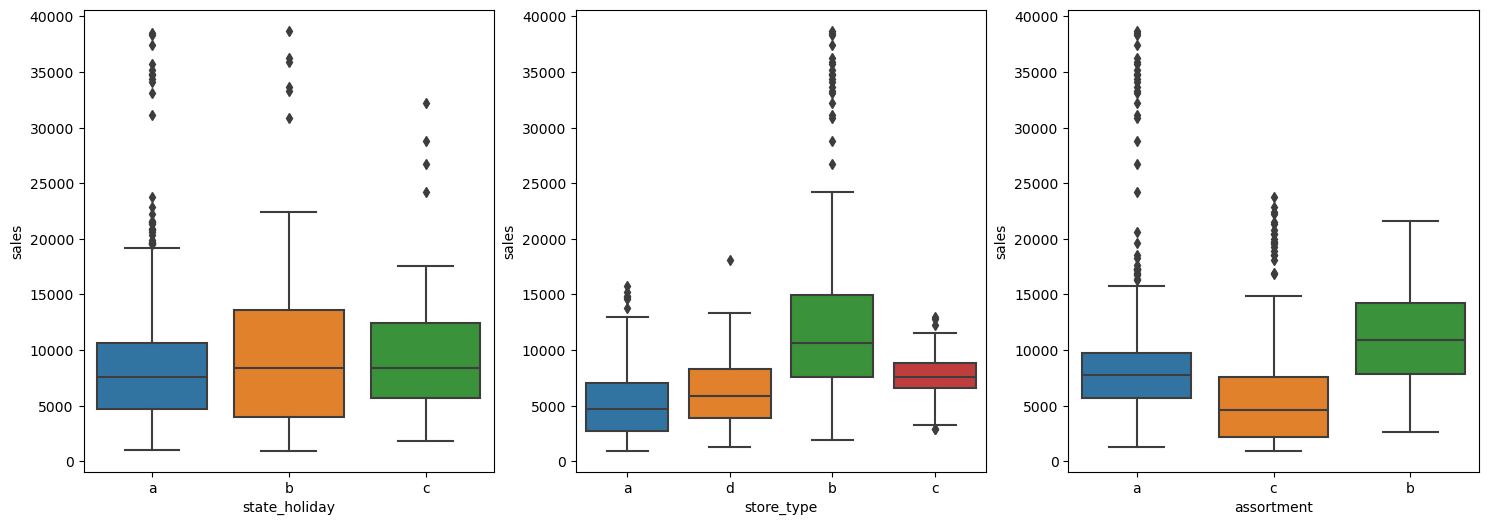

In [81]:
# Fazendo um filtro para retirar os dias em que a loja não esteve fechada
aux1 = df1[(df1['sales'] > 0 ) & ( df1['state_holiday'] != '0')]
plt.figure(figsize=(18, 6))

plt.subplot( 1, 3, 1)
sns.boxplot( x = 'state_holiday', y ='sales', data = aux1)

plt.subplot( 1, 3, 2)
sns.boxplot( x = 'store_type', y ='sales', data = aux1)

plt.subplot( 1, 3, 3)
sns.boxplot( x = 'assortment', y ='sales', data = aux1)


In [ ]:
# Assortment: Variedade de produtos ou itens.
# O tamanho da caixa(box) não está diretamente relacionado ao volume de vendas.

# 2.0 - Hypoteses Mindmap

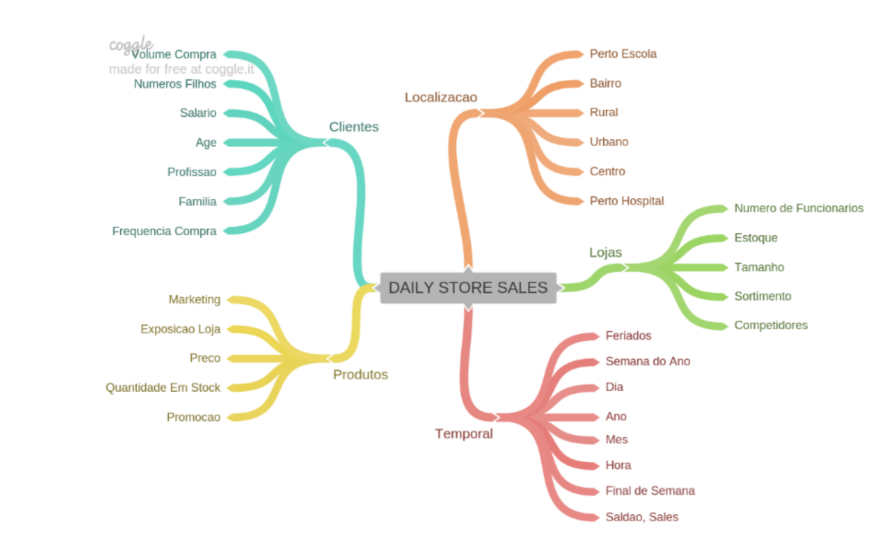

In [15]:
Image( '/home/aderaldo/estudos/comunidade_ds/Imagens/DAILY_STORE_SALES.png' )



## 2.1 - HYPOTHESES

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.
    
**3.** Lojas com competidores à mais tempo deveriam vendem mais.
    
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares

# 3.0 - Feature Engineering

In [11]:
df2 = df1.copy()

In [12]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_of_week'] = df2['date'].dt.strftime("%Y-%W")

# competition since
df2["competition_since"] = df2.apply( lambda x : datetime( year = x["competition_open_since_year"], month = x["competition_open_since_month"], day =1), axis = 1 )
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply( lambda x : x.days).astype(int)
# calculo da diferença entre as datas, mantendo a granulalidade mínima por mês. Extraindo o valor e convertendo para inteiro

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )

df2["promo_time_week"] = ((df2["date"] - df2["promo_since"]) / 7).apply( lambda x : x.days).astype( int)

# assortmant

df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday

df2["state_holiday"] = df2["state_holiday"].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christhmas' if x == 'c' else 'regular_day')

In [56]:
df2.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month_map,is_promo,year,month,day,week_of_year,year_of_week,competition_since,competition_time_month,promo_since
430384,780,3,2014-06-11,5282,693,1,0,0,0,a,...,Jun,0,2014,6,11,23-2014,2014-23,2014-06-01,0,2014-06-09


# 4.0 - Filtering Variables

In [13]:
df3 = df2.copy()

In [15]:
df3.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_of_week,competition_since,competition_time_month,promo_since,promo_time_week
2847,618,3,2015-07-29,8023,502,1,1,regular_day,1,d,...,0,2015,7,29,31,2015-30,2015-07-01,0,2015-07-27,0
148222,1043,6,2015-03-21,8304,1235,1,0,regular_day,0,c,...,0,2015,3,21,12,2015-11,2006-03-01,110,2015-03-16,0
860914,920,2,2013-05-21,4776,507,1,0,regular_day,1,a,...,0,2013,5,21,21,2013-20,2012-02-01,15,2014-09-29,-71


## 4.1 - Rows

- A coluna open só tem 2 valores: 1 para as lojas que estão aberta e 2 para as ques estão fechadas. Na questão
 do negócio quando as lojas estão fechadas as vendas são iguais a zero. Portanto preciso selecionar apenas os
 valores 1 da coluna Open.

- Também não interessa ao negócio as vendas serem iguais a zero.

In [14]:
df3 = df3[ ( df3["open"] != 0 ) & ( df3["sales"] > 0 ) ]

## 4.2 - Columns Selection

 - A razão para filtrar as variáveis é uma questão de restrição de negócio. A coluna costumers por exemplo, não é um dado que ajuda na previsão de negócio. Pois os dados de customers eu tenho naquele dia e não na previsão futura. Para isso eu teria que fazer um projeto a parte para descorbir quantos clientes eu vou ter nas próximas 6 semanas e utilizar esse dado. Neste caso é melhor descartar essa coluna.

In [23]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_of_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [15]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

In [16]:
df3 = df3.drop(cols_drop, axis = 1)
# axis = 0 linhas
# axis = 1 colunas

In [19]:
df3.shape

(844338, 25)

In [51]:
df2.shape

(1017209, 29)

# 5.0 - Exploratory Data Analysis (EDA)

In [18]:
df4 = df3.copy()

In [ ]:
# Como as variáveis impacttam esse fenômeno?
# Qual a força desse impacto?

## 5.1 - Univariate Analysis

### 5.1.1 - Response Variable

/tmp/ipykernel_298563/36890788.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df3['sales'])
/home/aderaldo/anaconda3/envs/DataScienceEmProducao/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sales', ylabel='Density'>

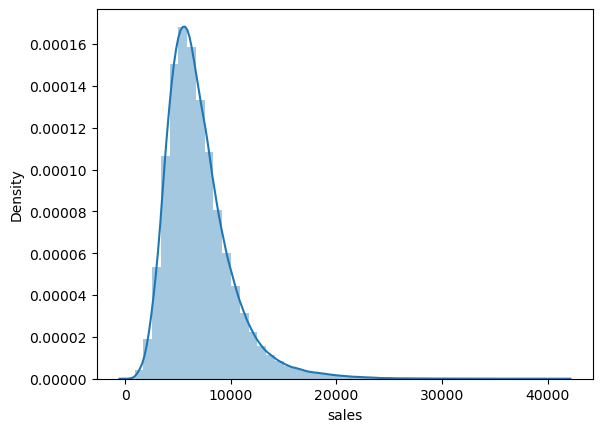

In [53]:
sns.distplot( df3['sales'])
# Quanto mais normal for a variável resposta, melhor o algoritmo vai performar.

/tmp/ipykernel_640239/340647188.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( np.log1p(df3['sales']))
/home/aderaldo/anaconda3/envs/DataScienceEmProducao/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sales', ylabel='Density'>

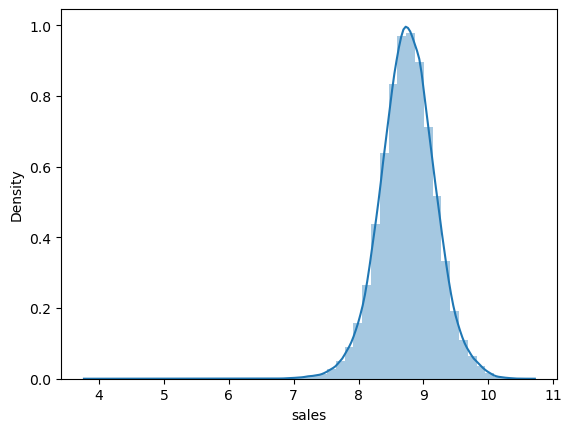

In [41]:
# Transformação para deixar a variável com comportamento mais normal
sns.distplot( np.log1p(df3['sales']))
# MUltiplica todos os valores de venda pelo log

### 5.1.2 - Numerical Variable

In [23]:
num_attributes = df4.select_dtypes( include = ['int64', 'float64'] )

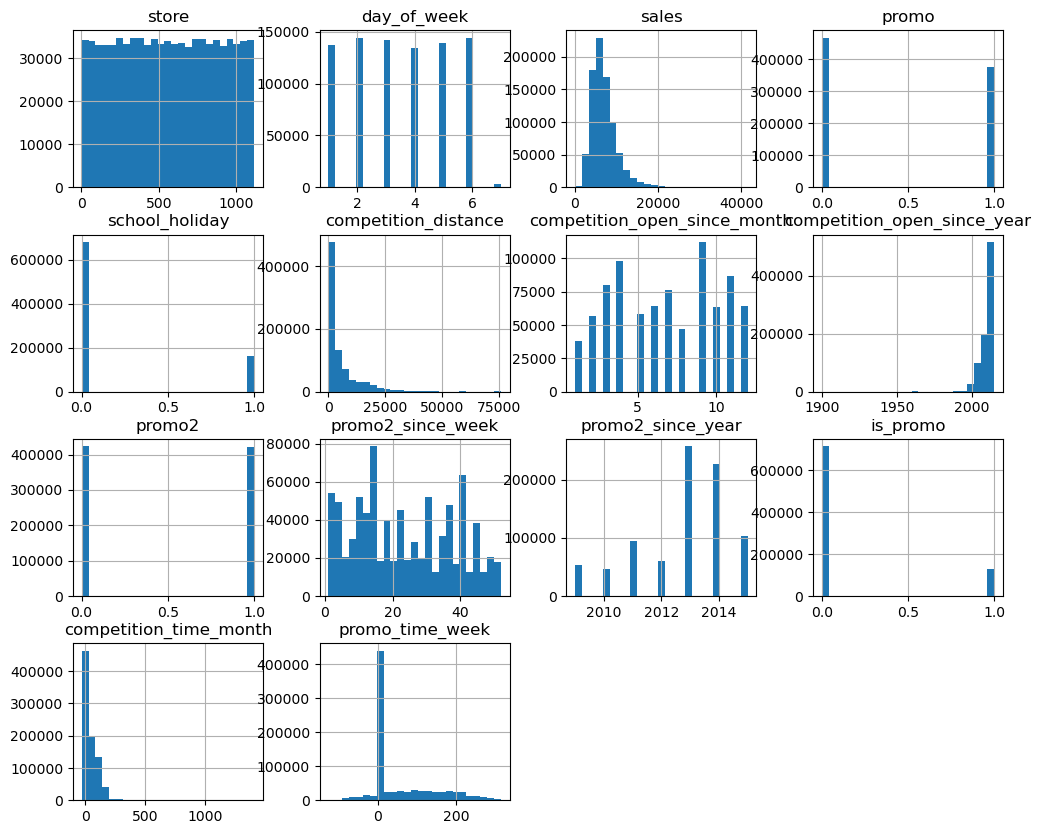

In [55]:
num_attributes.hist( bins = 25, figsize = (12, 10) );

- Segundo o hisotgrama acima a coluna day_of_week não explica muita coisa, pois seus valores são iguais.
- Segundo a coluna is_promo quando a loja não está em promoção, essas lojas apresentam mais linhas de vendas.
- Porque as lojas tiveram mais promoções em 2013 em relação aos outro anos?

### 5.1.3 - Categorical Variable

/home/aderaldo/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aderaldo/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aderaldo/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


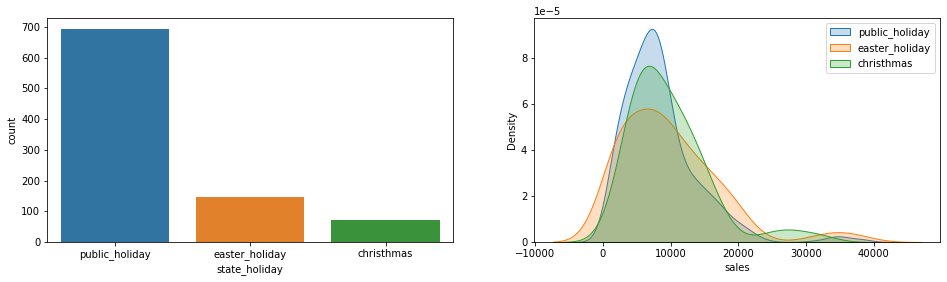

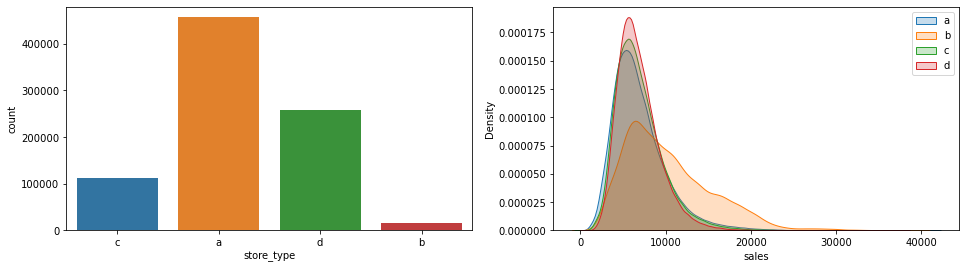

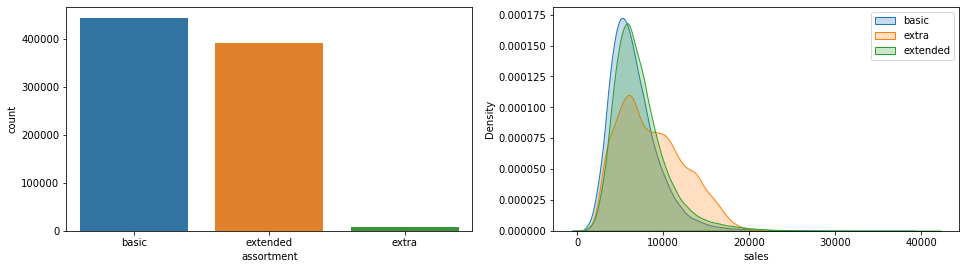

In [57]:
# state_holiday
plt.figure(figsize=(16, 14)) 
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
a.reset_index(drop=True, inplace=True)
sns.countplot( a['state_holiday'])
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christhmas']['sales'],label='christhmas', shade=True )
plt.legend()

# Store Type
plt.figure(figsize=(16, 14)) 
plt.subplot( 3, 2, 3 )
a.reset_index(drop=True, inplace=True)
sns.countplot( df4['store_type'])
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'],label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'],label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'],label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'],label='d', shade=True )
plt.legend()
# Assortment

plt.figure(figsize=(16, 14)) 
plt.subplot( 3, 2, 5 )
a.reset_index(drop=True, inplace=True)
sns.countplot( df4['assortment'])
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'],label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'],label='extra', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'],label='extended', shade=True )
plt.legend()

## 5.2 - Bivariate Analysis

### 1. Lojas com maior sortimentos deveriam vender mais.
***Falso!*** Segundo os dados, a nossa hipótese levantada acima é falsa, pois a categoria 'extra' que possui mais sortimentos teve menos vendas.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

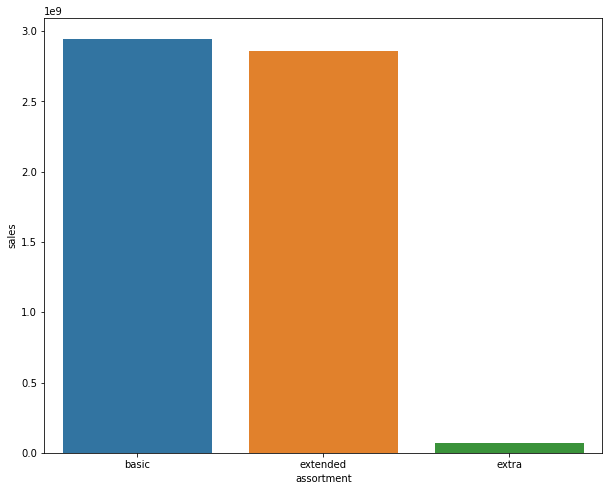

In [29]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(10, 8)) 
sns.barplot(x= 'assortment', y = 'sales', data = aux1)

<AxesSubplot:xlabel='year_of_week'>

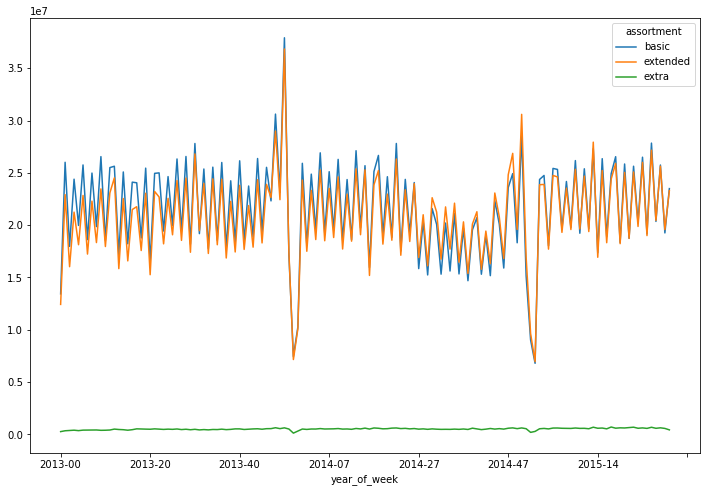

In [29]:
aux2 = df4[['year_of_week','assortment', 'sales']].groupby(['year_of_week','assortment']).sum().reset_index()
aux3 = aux2.pivot( index = 'year_of_week' , columns = 'assortment' , values = 'sales')
aux3.plot(figsize = (12,8))

### 2. Lojas com competidores mais próximos deveriam vender menos.
***Falso!*** as maiores vendas estão concentradas em competidores mais próximos.

<AxesSubplot:xlabel='competition_distance_binned', ylabel='sales'>

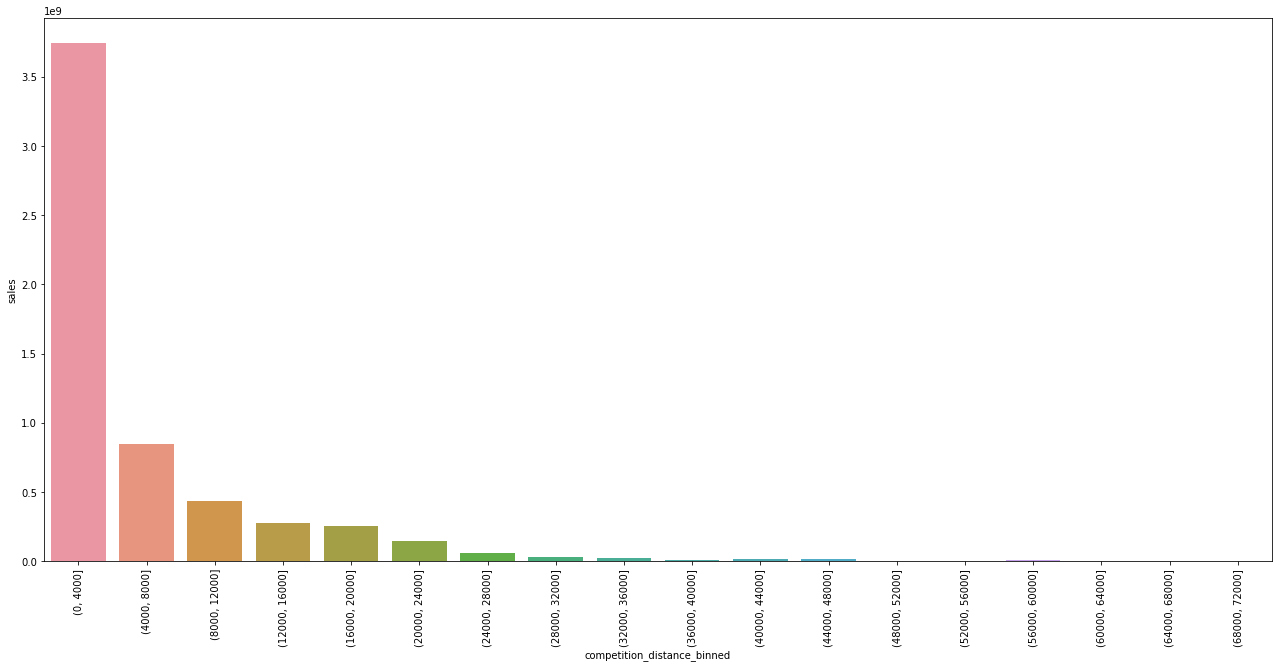

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list( np.arange(0, 75860, 4000 ))

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(22,10))
plt.xticks( rotation = 90)
sns.barplot(x= 'competition_distance_binned', y = 'sales', data = aux2 )

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

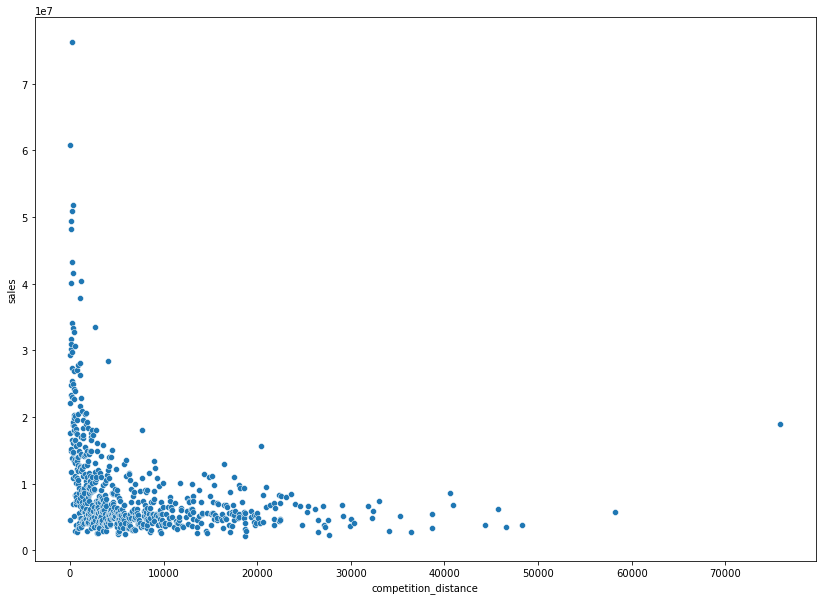

In [54]:
plt.figure( figsize = (14,10))
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1 )

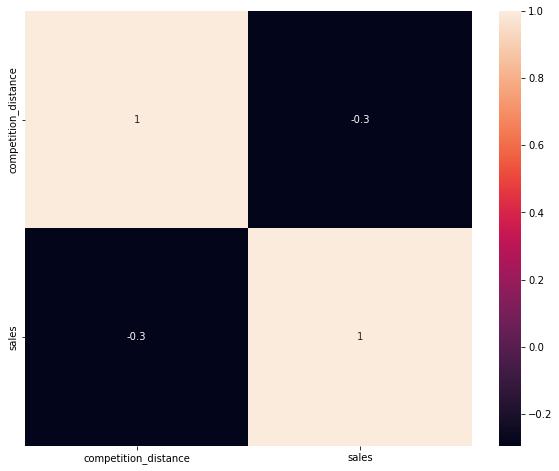

In [38]:
plt.figure( figsize = (10,8))
x = sns.heatmap( aux1. corr( method = 'pearson'), annot = True)


- A correlação de -0.3 indica que como o valor é negativo, quando mais a distancia aumenta a 
 venda diminui. Como o valor foi de -0.3 essa correlação tem um nível moderado.

### 3. Lojas com competidores a mais tempo deveriam vender mais.
**Falso!** as maiores vendas estão concentradas onda há grandes concorrências.

<AxesSubplot:xlabel='competition_year_binned', ylabel='sales'>

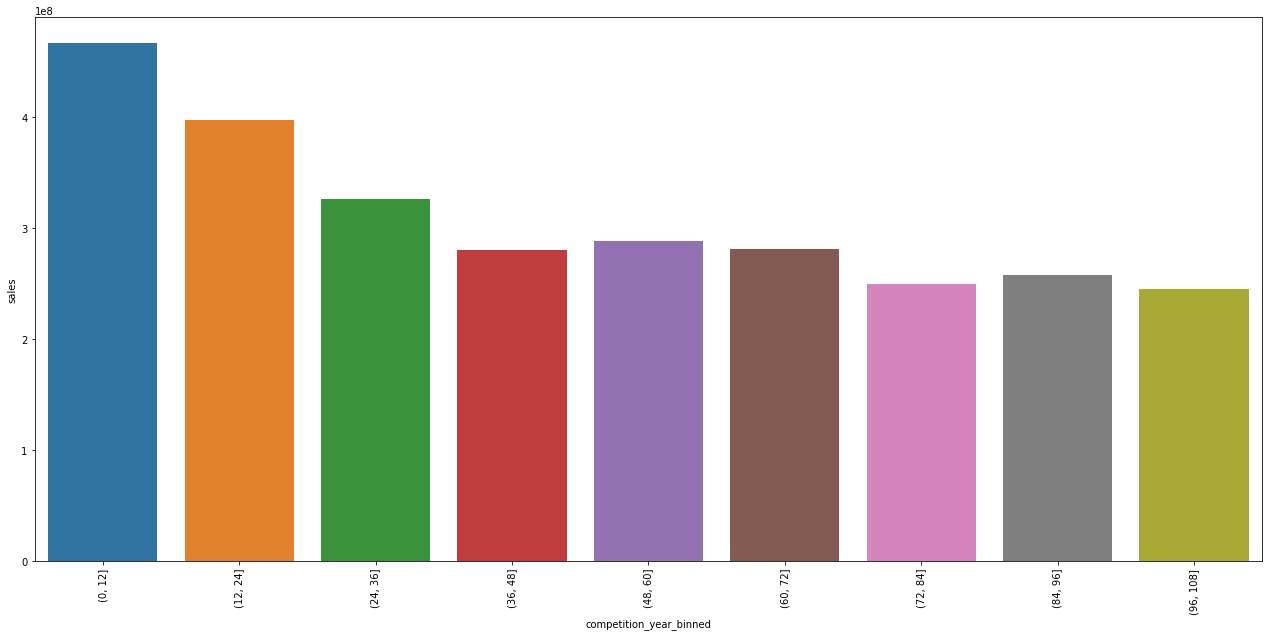

In [46]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

bins = list( np.arange(0, 120, 12 ))

aux1['competition_year_binned'] = pd.cut( aux1['competition_time_month'], bins = bins)

aux2 = aux1[['competition_year_binned', 'sales']].groupby('competition_year_binned').sum().reset_index()

plt.figure(figsize=(22,10))
plt.xticks( rotation = 90)
sns.barplot(x= 'competition_year_binned', y = 'sales', data = aux2 )

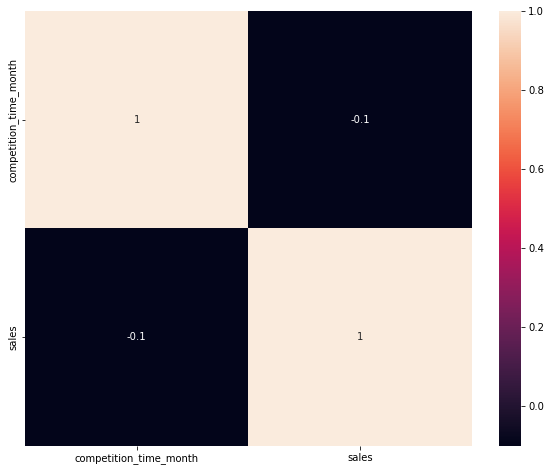

In [35]:
plt.figure( figsize = (10,8))
x = sns.heatmap( aux1. corr( method = 'pearson'), annot = True)

### 4.Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falso!** Pois lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

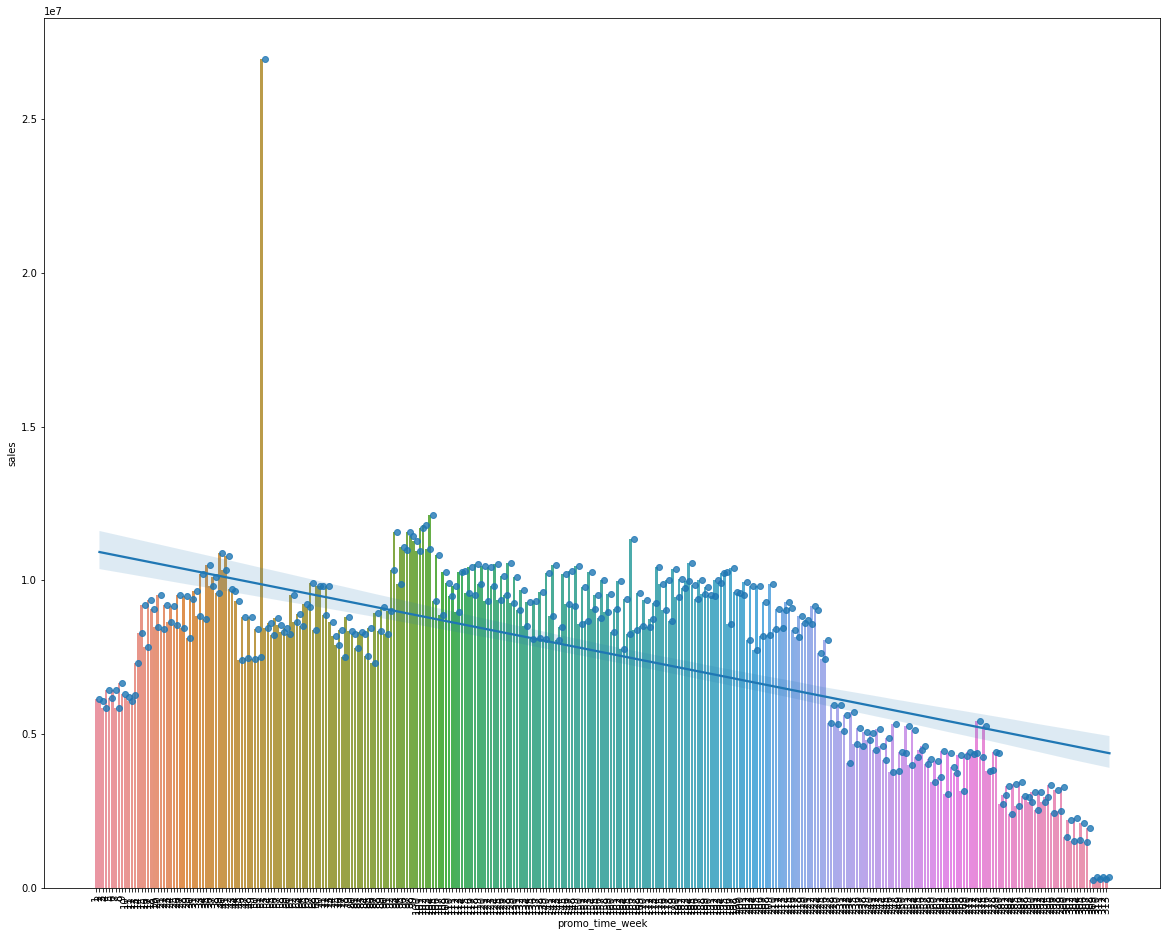

In [35]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


aux2 = aux1[aux1['promo_time_week'] > 0 ] # Promoção extendida
plt.figure( figsize = (20,16))
plt.xticks( rotation = 90)
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2 )

sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 )


<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

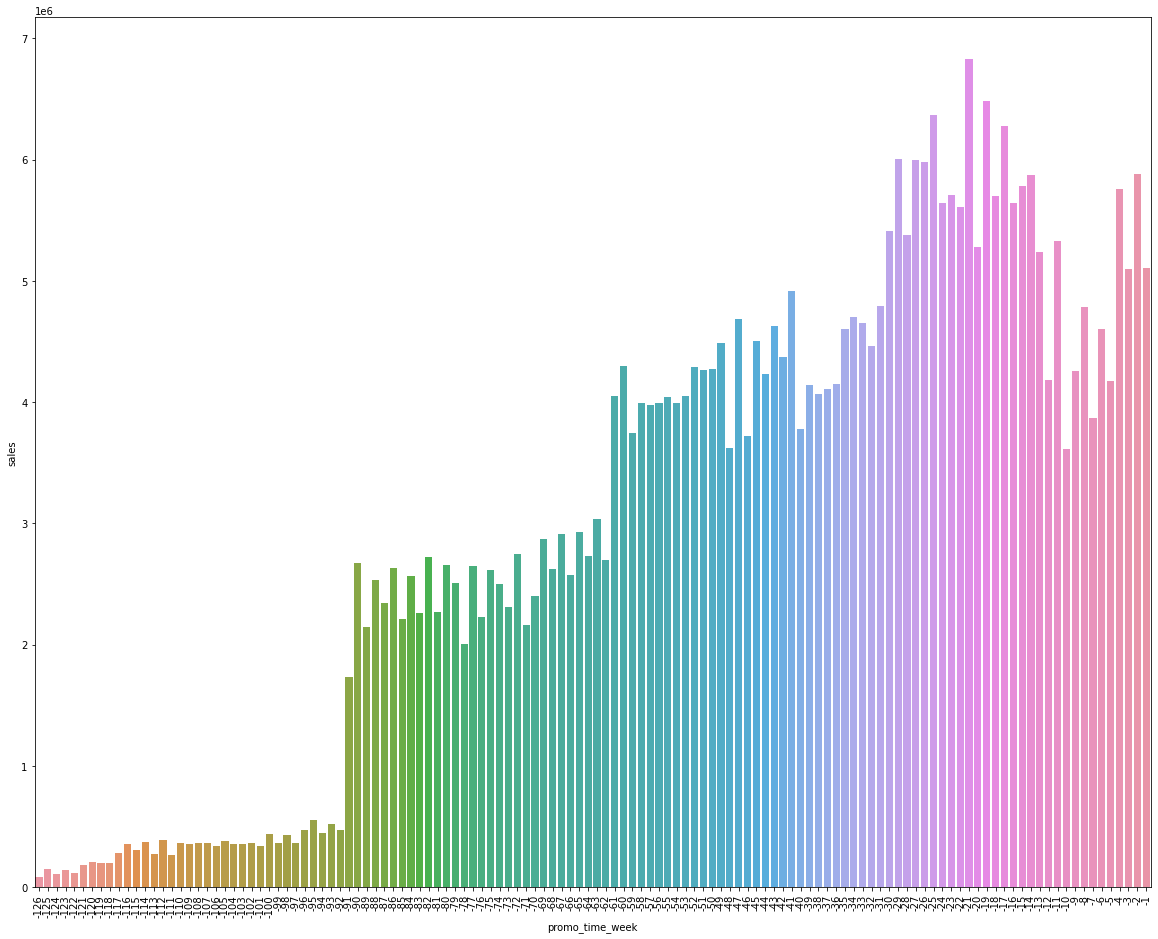

In [45]:
aux3 = aux1[aux1['promo_time_week'] < 0 ] # Promoção regular
plt.figure( figsize = (20,16))
plt.xticks( rotation = 90)
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3 )




<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

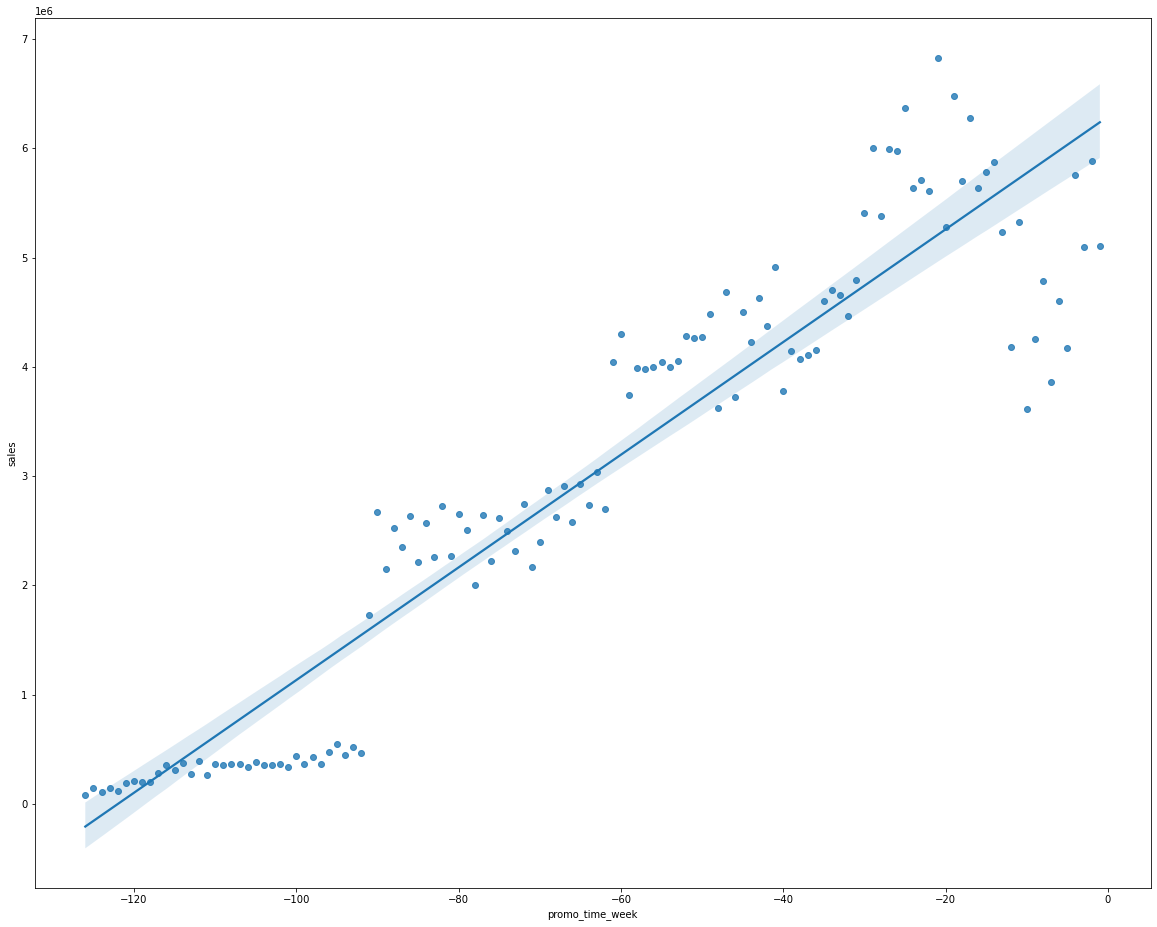

In [48]:
plt.figure( figsize = (20,16))
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3 )


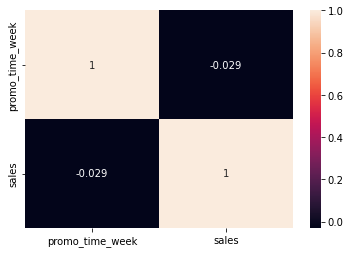

In [62]:
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> 5. Lojas com mais dias de promoção deveriam vender mais.</s>


### 6.Lojas com mais promoções consecutivas deveriam vender mais.
**Falso!** Pois lojas com promoções consecutivas vendem menos

In [63]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


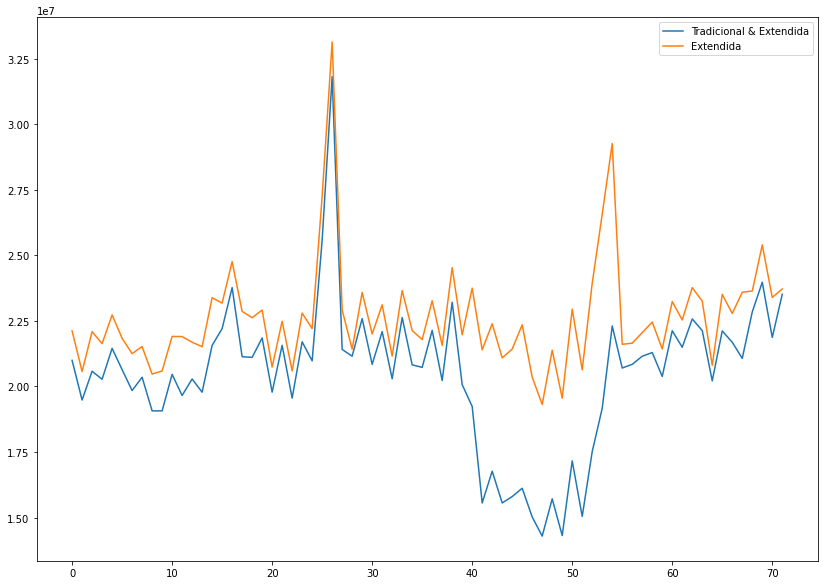

In [80]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_of_week','sales']].groupby( 'year_of_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_of_week','sales']].groupby( 'year_of_week' ).sum().reset_index()
aux2.plot( ax=ax, figsize = (14,10) )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### 7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falso!** O feriado de natal concentram as menores vendas

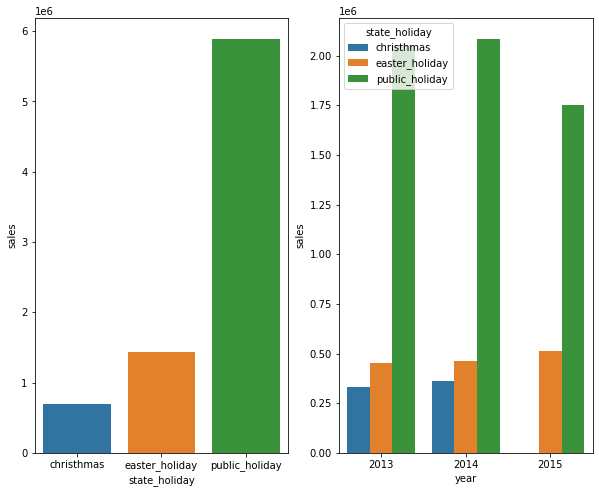

In [91]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.figure(figsize = (10, 8))
plt.subplot( 1, 2, 1  )

aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )

aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### 8. Lojas deveriam vender mais ao longo dos anos.
**Falso!** As lojas vendem menos ao longo dos anos.

<AxesSubplot:>

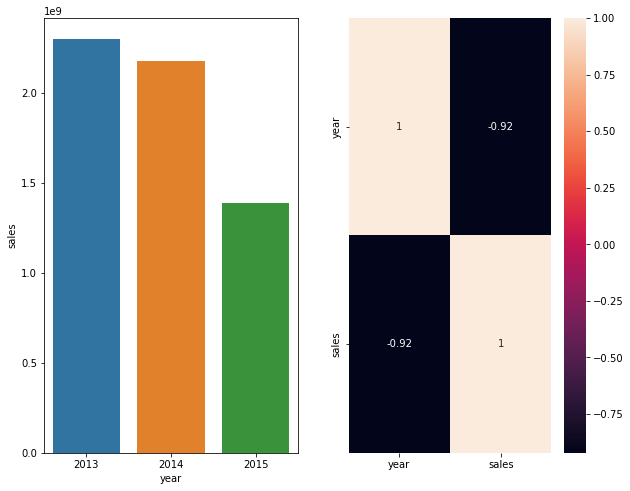

In [106]:
plt.figure(figsize = (10, 8))
plt.subplot(1,2,1)
aux1 = df4[['sales', 'year']].groupby('year').sum().reset_index()
sns.barplot( x = 'year', y = 'sales', data = aux1)
plt.subplot(1,2,2)

sns.heatmap( aux1.corr( method='pearson' ), annot=True )

In [ ]:
# COnforme os anos vão passando as vendas vão caindo. Um detalhe importante é que o ano de 2015 não está fechado!

### 9. Lojas deveriam vender mais no segundo semestre do ano.
**Falso!** As lojas vendem menos no segundo semestre do ano.

<AxesSubplot:>

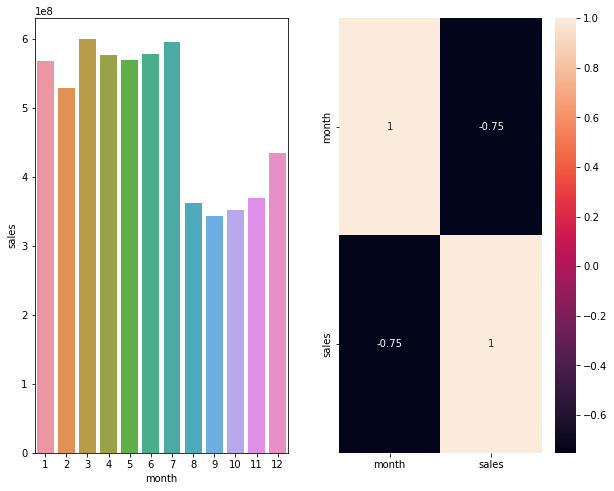

In [108]:
plt.figure(figsize = (10, 8))
plt.subplot(1,2,1)
aux1 = df4[['sales', 'month']].groupby('month').sum().reset_index()
sns.barplot( x = 'month', y = 'sales', data = aux1)
plt.subplot(1,2,2)

sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### 10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeiro!** As lojas vendem mais após o dia 10 de cada mês.


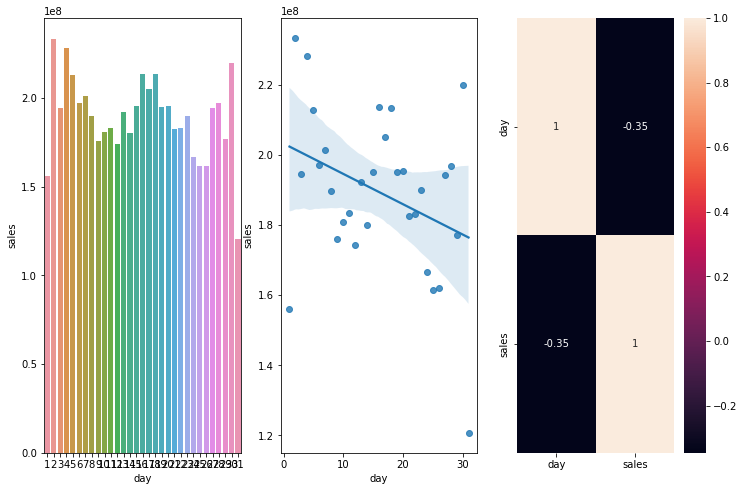

In [113]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
aux1 = df4[['sales', 'day']].groupby('day').sum().reset_index()
sns.barplot( x = 'day', y = 'sales', data = aux1)

plt.subplot( 1, 3, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )



In [120]:
aux1['before_after'] = aux1['day'].apply( lambda x : 'after' if x > 10 else 'before' )

<AxesSubplot:xlabel='before_after', ylabel='sales'>

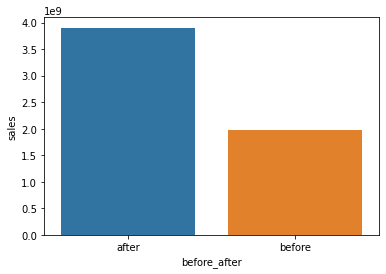

In [123]:
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2)

### 11. Lojas deveriam vender menos aos finais de semana.
**Verdadeiro!** As lojas vendem menos nos finais de semana.


<AxesSubplot:>

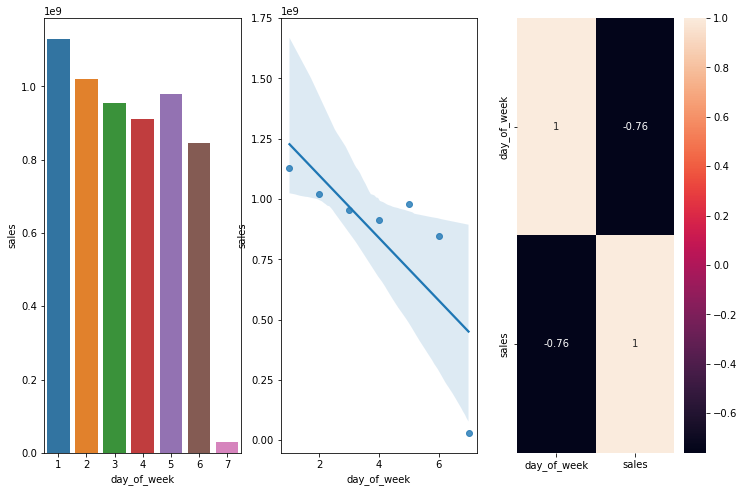

In [125]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
aux1 = df4[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )


In [124]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_of_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### 12. Lojas deveriam vender menos durante os feriados escolares
**Verdadeiro!** As lojas vendem menos durante os feriados escolares.


<AxesSubplot:xlabel='month', ylabel='sales'>

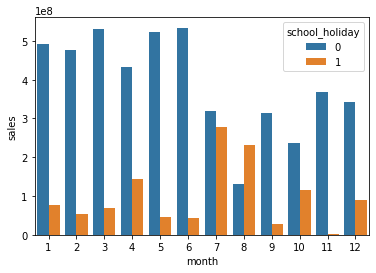

In [137]:
aux1 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue='school_holiday', data = aux1 )

### Resumo

In [20]:
from tabulate import tabulate

In [21]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 5.3 - MultiVariate Analysis

- Avalia as variáveis procurando por dependências

## 5.3.1 - Numerical Attributes

<AxesSubplot:>

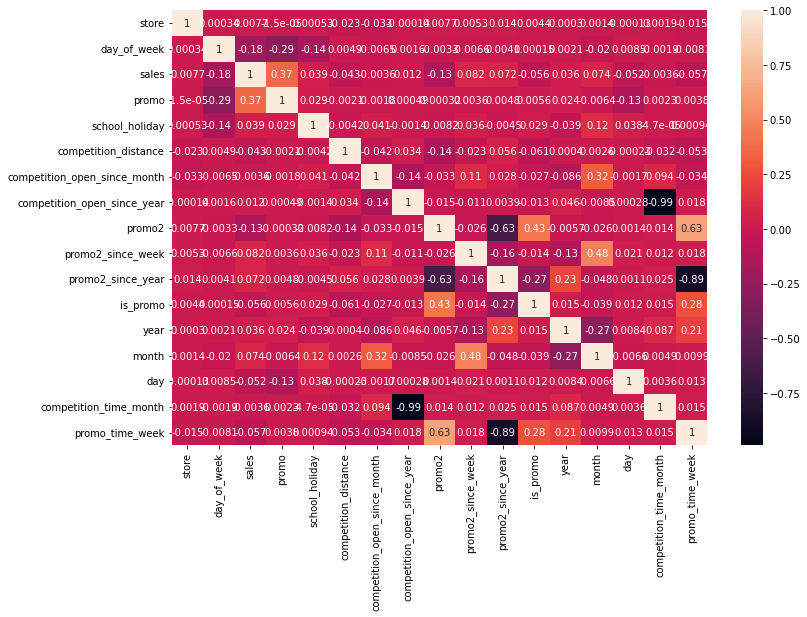

In [27]:
correlation = num_attributes.corr( method = 'pearson')
plt.figure( figsize = (12, 8) )
sns.heatmap( correlation, annot = True )

## 5.3.2 - Categorical Attributes

<AxesSubplot:>

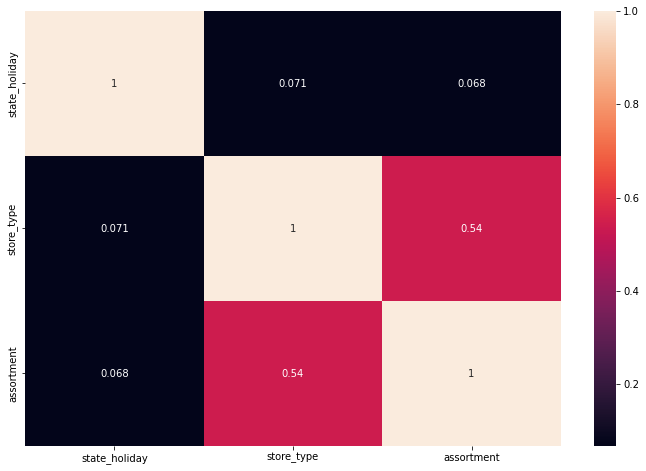

In [37]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
plt.figure( figsize = (12, 8) )
sns.heatmap( d, annot=True )

In [ ]:
# Quanto maior o tipo da loja mais variedades ela tem.

# 6.0 - Data Preparation

No dataset em questão temos alguns problemas com as colunas categoricas e também temos problemas com a range das colunas que variam MUITO. Em alguns modelo de ML esses valores muito grande acabam influenciando fortemente o resultado do modelo.

**Normalização** é muito usada quando temos um distribuição normal. **Rescaling** é usada quando não temos um distribuição normal.

In [19]:
df5 = df4.copy()

## 6.1 - Normalization

In [ ]:
Pelo gráficos obtidos na seção de *Univariate Analysis* não consta nenhuma distribuição normal
sendo assim não é necessário aplicar esse técnica.

## 6.2 - Rescaling

O *min-max* scaler não muda a natureza da distribuição, porém é sensível a outliers. Por isso é ideal usar o robust scaler nesses casos.

In [20]:
a = df5.select_dtypes( include = ['int64', 'float64'])

In [21]:
# Selecionar as colunas
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


/home/aderaldo/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

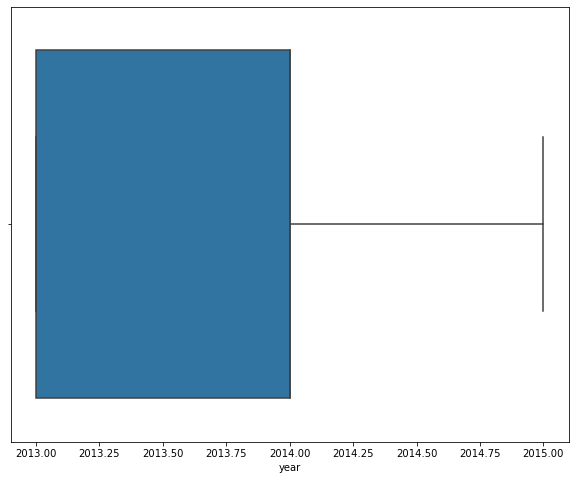

In [33]:
# Usado para verificar os outliers
plt.figure(figsize = (10, 8))
sns.boxplot( df5['year'])

In [1]:
pwd

'/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao'

In [22]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance -  tem outliear
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/parameter/competition_distance_scaler.pkl', 'wb') )

# competition_time_month - tem outliers
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( '/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/parameter/competition_time_month_scaler.pkl', 'wb') )

# promo_time_week - tem outilers, mas vou arriscar
df5["promo_time_week"] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( '/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/parameter/promo_time_week_scaler.pkl', 'wb') )

# Year - Não tem outliers
df5["year"] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/parameter/year_scaler.pkl', 'wb') )

## 6.3 - Encoding

In [23]:
a = df5.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

In [24]:
# state_holiday - One hot enconding já que a variável lida com estado
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )


# store_type - Label enconding já que a variável não tem ordem de grandeza.
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( '/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/parameter/store_type_scaler.pkl', 'wb') )

# assortment - Manual ordinal enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

## 6.4 - Transform

A variável resposta tem que ter um comportamento de **grandeza** **Normal**, e as variavéis de data( mês, dia, semana) precisam ter uma transformação na sua **natureza** com intuito do modelo entende-lás como um **ciclo**.

In [25]:
# Aplicação de um função logaritmica na variável resposta
df5['sales'] = np.log1p( df5['sales'] )

In [27]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_of_week                            object
competition_since               datetime64[ns]
competition_t

In [26]:
# Aplicação de transformação de natureza

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12  ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )



# 7.0 - Feature Selection

Removendo as variáveis colineares.

**1** Seleção univariada ( Filter Methods )

Dentre todas as variáveis disponíveis, quais explicam melhor a variável respota.
**Vantagens:** Simples, rápido e fácil entendimento.
**Desvantagens:** Uma variável fraca pode não impactar no modelo. Porém a combinação dessa variável com outra pode causar um efeito inverso. A desvantagem dessa técnica seria o descarte precoce dessa variável.

- Utiliza a correlação como critério de seleção.

**2** Seleção por importância ( Embedded Methods )

- Utiliza do critério de gini do allgoritmo Random Forest para fazer a seleção de variáveis
- Os algoritsmo de regularização lasso e o Ridge também selecionam as variáveis através de pesos

**3** Seleção por subset ( Wrapper Methods )
**Algoritmo Boruta - Funcionamento**

- Seleciona 2 váriaveis
- Copia os msm valores das duas variáveis, porém com os elementos embaralhados(shadow), com o intuito da correlação ser a mesma já que os dados são os mesmos.
- Treianmento do modelo com a Random Forest
- O valor de cada variável é comparado com o maior valor da shadow
- Os resultados que forem maior do que o valor da shadow são marcados com 1 e os menos são marcados com 0
- Depois há uma distribuição binominal para calcular o p-value
- A partir do p-value as variáveis são selecionada

## 7.2 - Feature Selection ( Boruta implementation )

In [24]:
df6 = df5.copy()

In [25]:
# Deletando as colunas originais das derivações dos passos anteriores
cols_drop = ['week_of_year', 'month', 'day_of_week', 'day', 'promo_since', 'competition_since', 'year_of_week' ]

df6 = df6.drop( cols_drop, axis = 1 )

### 7.2.1 - Split dataset into trainning and test dataset

Como esse problema de negócio é temporal. Essa divisão de treino e teste tem que seguir uma lógica. Pois se não houver a separação adequada o algoritmo vai overfitar.

**Divisão:** As ultimas 6 semanas de vendas vão ser seleciondas como TESTE, e o restante das datas serão consideradas com TREINO.

In [26]:
df6['date'].max()

data_limite = df6['date'].max() - timedelta( days = 6*7)

In [30]:
data_limite

Timestamp('2015-06-19 00:00:00')

In [27]:
X_train = df6[df6['date'] < data_limite]
y_train = X_train['sales']

X_test = df6[df6['date'] >= data_limite]
y_test = X_test['sales']

In [40]:
len(X_train.columns)

29

In [29]:
X_train['date'].max()

Timestamp('2015-06-18 00:00:00')

In [33]:
x_test['date'].min()

Timestamp('2015-06-19 00:00:00')

### 7.2.2 - Boruta as Feature Selector

In [30]:
# Removendo a variável resposta do X_train e a coluna do tipo date
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values

# Transformando o dataframe em um uníco vetor
y_train_n = y_train.values.ravel()

In [31]:
# n_jobs = -1 é um parâmetro onde o modelo vai utilizar todos os cores da máquina,e faça 
# todo o processamento em paralelo. Com isso a criação da arvóres se torna mais rápida
rf = RandomForestRegressor( n_jobs=-1 )

# n_estimators é o número de arvores que o proprio modelo vai se ajutar automaticamente
# verbose = 2 significa que o eu consigo ver o que o modelo está executando
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


KeyboardInterrupt: 

In [ ]:
# parametro que rankeia as variáveis por relevânica
cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

# Seleção por índices
cols_selected_boruta = X_train_fs.iloc[ : , cols_selected ].columns.tolist()

## not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

### 7.2.3 - Manual Feature Selection

- Em comparação com as hipotéses com relevância apontadas em etapas anteriores, apenas a variável 'month' não foi considerada relevante pelo **Boruta**. 
- As variáveis 'day_of_week_sin' e 'month_sin' não foram consideradas relevantes para o Boruta. Mas vão entrar como importantes por fazerem parte de um mesmo contexto.

In [28]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']
# Adicioanando de volta as duas colunas para o treinamento
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 8.0 - Model Trainning

In [31]:
# Nesse primeiro ciclo não vou utilizar das conlunas 'date' e 'sales'
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Pegandos todas as variáveis selecionadas pelo boruta
x_training = X_train[ cols_selected_boruta_full ]

## 8.1 - Average Model

É o primeiro modelo a se criar, sua utilizada é servir como parâmetro para os próximos modelos.

In [30]:
aux1 = x_test.copy()

aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )

# yhat na matemática é conhecida como a predição
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model,Mae,Mape,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


No calculo da performance foi necessário passar o exponencial para cancelar a transformação da variável reposta obtida na seção **6.4**.

## 8.2 - Linear Models

Os modelo lineares são mais simples, mesmo o conjunto de dados ser caracterizado por ser mais complexo, é necessário começar por modelo mais simples.


### 8.2.1 - Linear Regression

In [46]:
model_lr = LinearRegression()
# fit
lr = model_lr.fit( x_train, y_train )

#predict
y_hat_lr = lr.predict( x_test )

# performance

lr_result = ml_error( 'Linear Model', np.expm1( y_test ), np.expm1(y_hat_lr ) )
lr_result

,Model,Mae,Mape,RMSE
0,Linear Model,1871.29926,0.293322,2671.446128


### 8.2.2 - Linear Regression CV

In [41]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.9 +/- 295.77,0.3 +/- 0.02,2949.75 +/- 468.9


## 8.2.3 - Linear Regression Lasso

In [44]:
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model,Mae,Mape,RMSE
0,Linear Regression - Lasso,1893.668576,0.289341,2744.612075


Pelos resultados obtidos o dataset não parece ter um comportamento linear.

## 8.2.4 - Linear Regression Lasso CV

In [45]:
lrl_result_cv = cross_validation( x_training, 5, 'Linear Regression Lasso', lrr, verbose=False )

## 8.2 - Complex Models

São modelos mais complexos com o objetivo de entender mais os dados.

## 8.2.1 - Random Forest Regressor

In [ ]:
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )
# prediction
yhat_rf = rf.predict( x_test )
# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

## 8.2.2 - Random Forest Regressor CV

In [ ]:
rfr_result_cv = cross_validation( x_training, 5, 'Linear Regression Lasso', rf, verbose=False )

## 8.2.3 - XGBoost Regressor

In [32]:
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                         n_estimators = 100,
                         n_jobs = -1,
                         eta = 0.01,
                         max_depth = 10,
                         subsample = 0.7,
                         ).fit( x_train, y_train )
# eta é o parâmetro que contabiliza quantos passadas o algoritmo dá para o aprendizado.
# subsample = 0.7, significar que o algoritmo irá utilizar 70% das variáveis de treinamento.
# fit

#predict
y_hat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGB', np.expm1( y_test ), np.expm1( y_hat_xgb ) )
xgb_result

KeyboardInterrupt: 

## 8.2.4 - XGBoost Regressor CV

In [34]:
xbg_result_cv = cross_validation( x_training, 5, 'XGBosst Regressor', model_xgb, verbose=False )
xbg_result_cv 

/home/aderaldo/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:19:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/aderaldo/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:20:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/aderaldo/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:21:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/aderaldo/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:22:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/aderaldo/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:23:14] WARNING: /

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBosst Regressor,1861.17 +/- 289.42,0.25 +/- 0.01,2683.65 +/- 425.56


## 8.3 - Compare Models

In [48]:
models = pd.concat( [ baseline_result, lr_result, rf_result, xgb_result ] )
models.sort_values(by = "RMSE", ascending = True)

,Model,Mae,Mape,RMSE
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Model,1871.299260,0.293322,2671.446128
0,Linear Model,1871.299260,0.293322,2671.446128
0,XGB,1871.299260,0.293322,2671.446128


In [48]:
models = pd.concat( [ lr_result_cv, lrl_result_cv, rfr_result_cv, xbg_result_cv ] )
models.sort_values(by = "RMSE", ascending = True)

Apesar do resultado da random forest ser melhor, o modelo a ser escolhido vai ser o xboost. Pois a random forest custa muito, e a diferença entre os resultados de ambos os modelo não é grande.

# 9.0 - Fine Tuning

Apesar do Fine tuning ser uma técnica importantíssima para aprimoramento do modelo. O que realmente vai impactar no seu desempenho é a análise das features.

## 9.1 - Random Search

- Essa estratégia é caracterizada pela escolha dos valores dos principais parâmetros de forma totalmente arbitária e aleatória.

- É mais rápido. Porém corre o risco de não achar os melhores valores.

In [33]:
param = {
    
 'n_estimators': [1500, 1700, 2500, 3000, 3500],
 'eta': [0.01, 0.03],
 'max_depth': [3, 5, 9],
 'subsample': [0.1, 0.5, 0.7],
 'min_child_weight': [3, 8, 15]
 
}
MAX_EVAL = 2

In [32]:
hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
hp

{'n_estimators': 3500,
 'eta': 0.01,
 'max_depth': 5,
 'subsample': 0.7,
 'min_child_weight': 15}

In [41]:
for k, v in param.items():
    print(v)

[1500, 1700, 2500, 3000, 3500]
[0.01, 0.03]
[3, 5, 9]
[0.1, 0.5, 0.7]
[3, 8, 15]


In [ ]:
final_result = pd.DataFrame()
for i in range( MAX_EVAL ):
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                         n_estimators = hp['n_estimators'],
                         n_jobs = -1,
                         eta = hp['eta'],
                         max_depth = hp['max_depth'],
                         subsample = hp['subsample'],
                         min_child_weight = hp['min_child_weight']
                         ).fit( x_train, y_train )
    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] ) 
    
final_result 

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3


### 9.1.2 - Final Mode

In [29]:
# Melhores parametros segundo o fine tuning
param_tuned = {
    
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [33]:
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                         n_estimators = param_tuned['n_estimators'],
                         n_jobs = -1,
                         eta = param_tuned['eta'],
                         max_depth = param_tuned['max_depth'],
                         subsample = param_tuned['subsample'],
                         min_child_weight = param_tuned['min_child_weight']
                         ).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb.predict( x_test )

# performance
xgb_result_tuned = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_tuned


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,958.34 +/- 133.31,0.14 +/- 0.02,1366.35 +/- 184.06


**MAE**: As previsões do modelo estão desviando em média de 958 unidades da verdadeira resposta, com um desvio padrão de mais ou menos 133.

**MAPE**: O modelo está errando em média cerca de 14%.

**RMSE**: É utilizado para avalir a performance do modelo. Como a métrica é sensível a outliers. Eu posso adotar alguma política de tratamento desses outliers e melhorar o resultado do modelo.

- o RMSE e o MPE são mais utilizados para corrigir e avaliar o modelo, o MAE e MAPE são mais utilizados para apresentar os dados ao time de negócio.

In [38]:
# Model save
pickle.dump( model_xgb, open( '/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/model/model_rossman.pkl', 'wb' ) ) 

In [35]:
pwd


'/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao'

#### 9.1.3 - Calculating MPE error

In [34]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.016464783168001415

- Esse erro tem como característica avaliar se o modelo está superestimando os valores ou subestimando. Como o valor foi negativo, significa que o modelo está superestimando as vendas.

#### 9.1.4 - Grid Search

 - Vai testar todas as possibilidade de combinações, porém é bem mais custoso em relação ao tempo.

#### 9.1.5 - Bayseian Search

- Utiliza o aprendizado das possibilidades dos valores como guia para se chegar no valor ideal.

# 10.0 - Final Analyses

In [39]:
df7 = X_test[ cols_selected_boruta_full ]

# rescale

df7['sales'] = np.expm1( df7['sales'] )
df7['predictions'] = np.expm1( yhat_xgb_tuned )

/tmp/ipykernel_82440/2029025153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['sales'] = np.expm1( df7['sales'] )
/tmp/ipykernel_82440/2029025153.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['predictions'] = np.expm1( yhat_xgb_tuned )


## 10.1 - Business Analyses

In [65]:
# sum store x predctions
df71 = df7[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE
df71_aux = df7[['store', 'sales', 'predictions']].groupby('store').apply( lambda x : mt.mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns = { 0 : 'MAE' })

# MAPE
df71_aux2 = df7[['store', 'sales', 'predictions']].groupby('store').apply( lambda x : mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0 : 'MAPE'})

# Merge
df71_aux3 = pd.merge( df71_aux, df71_aux2, how = 'inner', on = 'store')
df_final = pd.merge( df71, df71_aux3, how = 'inner', on = 'store' )

# Scenarios
df_final['worst_scenario'] = df_final['predictions'] - df_final['MAE']
df_final['best_scenario'] = df_final['predictions'] + df_final['MAE']

# order columns
df_final = df_final[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [69]:
df_final.sort_values( by = 'MAPE', ascending = False).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107921.703125,104494.650493,111348.755757,3427.052632,0.618386
908,909,226451.406250,218558.944293,234343.868207,7892.461957,0.525110
594,595,285873.875000,279297.141536,292450.608464,6576.733464,0.455253
875,876,197534.125000,193507.032577,201561.217423,4027.092423,0.322488
955,956,141738.625000,140933.926830,142543.323170,804.698170,0.317550
748,749,209581.640625,208503.003141,210660.278109,1078.637484,0.296536
901,902,190718.500000,189561.459585,191875.540415,1157.040415,0.289620
674,675,155314.234375,154517.051877,156111.416873,797.182498,0.257350
270,271,265520.750000,264085.661925,266955.838075,1435.088075,0.257220
827,828,223906.562500,222924.653690,224888.471310,981.908810,0.254492


<AxesSubplot:xlabel='store', ylabel='MAPE'>

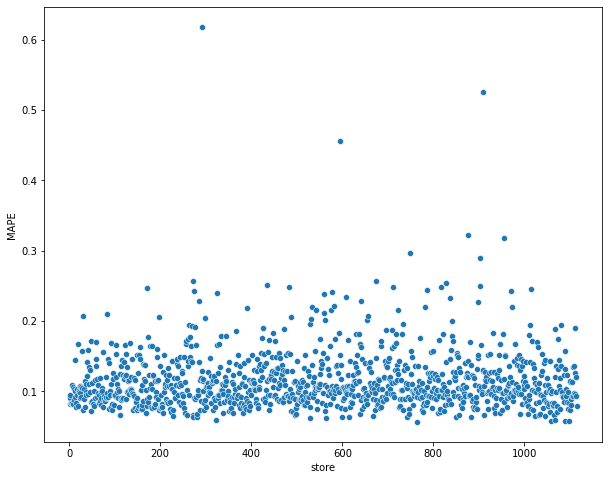

In [73]:
plt.figure( figsize = ( 10, 8 ) )
sns.scatterplot( x = 'store', y = 'MAPE', data = df_final )

In [81]:
df_final2 = df_final[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x : np.sum( x ), axis = 0 ).reset_index().rename( columns = {'index' : 'Scenario', 0 : 'values' })
df_final2['values'] = df_final2['values'].map('R$ {:,.2f}'.format)

In [82]:
df_final2

,Scenario,values
0,predictions,"R$ 286,334,592.00"
1,worst_scenario,"R$ 285,473,786.37"
2,best_scenario,"R$ 287,195,415.26"


## 10.2 - Machine Learning Performance

In [84]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales']

/tmp/ipykernel_82440/1370162162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['error'] = df7['sales'] - df7['predictions']
/tmp/ipykernel_82440/1370162162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['error_rate'] = df7['predictions'] / df7['sales']


/home/aderaldo/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aderaldo/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

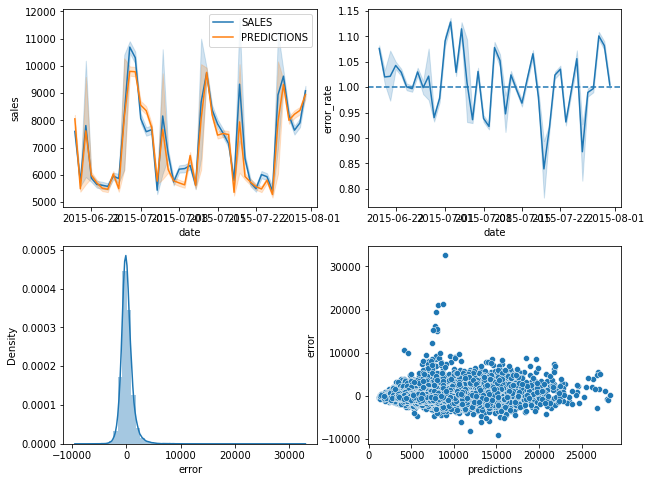

In [86]:
plt.figure(figsize=(10, 8)) 
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df7, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df7, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df7 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df7['error'] )
plt.subplot( 2, 2, 4 )

sns.scatterplot( df7['predictions'], df7['error'] )

# 11.0 - Deploy 

## 11.1 - Rossman Class

In [1]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
import os

# Criar a classe Rossman contendo todos os processos de transformação e limpeza de dados
class Rossmann( object ):
    
    def __init__( self ):
        
        parameters = ['competition_distance_scaler', 'competition_time_month_scaler', 'promo_time_week_scaler', 'year_scaler', 'store_type_scaler' ]
        caminho = []
        for parameter in parameters:
            
            diretorio_atual = os.path.dirname( __file__ )
            caminho_arquivo = os.path.join( diretorio_atual, 'parameter/{}.pkl'.format( parameter ) )
            caminho.append( caminho_arquivo )
        
        self.competition_distance_scaler = pickle.load( open( caminho[0], 'rb') )
        self.competition_time_month_scaler = pickle.load( open( caminho[1], 'rb') )
        self.promo_time_week_scaler = pickle.load( open( caminho[2], 'rb') )
        self.year_scaler = pickle.load( open( caminho[3], 'rb') )
        self.store_type_scaler = pickle.load( open( caminho[4], 'rb') )
    
    # O parametro Self é usado para acessar atributos e métodos da instância dentro da classe
    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns
        
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
        
        # competition_distance
        # É a distância entre os competidores
        # subistitui os valores ausente pelo valor máximo encontrado nessa coluna;
        max_valor = df1["competition_distance"].max()

        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_valor if pd.isnull(x) else x)

        # competition_open_since_month
        # É um numero contendo o mês e ano que a loja competidora foi aberta
        # A lógica para a subistituição vai ser a extração do valor do mês da coluna data;
        df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)

        # competition_open_since_year
        # A mesma lógica do exemplo anterior
        df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)

        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        
        #change dtypes
        df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int) 
        df1["competition_open_since_year"] =  df1["competition_open_since_year"].astype(int)
        df1["promo2_since_week"] =  df1["promo2_since_week"].astype(int)
        df1["promo2_since_year"] =  df1["promo2_since_year"].astype(int)
        
        return df1
    
    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_of_week'] = df2['date'].dt.strftime("%Y-%W")

        # competition since
        df2["competition_since"] = df2.apply( lambda x : datetime( year = x["competition_open_since_year"], month = x["competition_open_since_month"], day =1), axis = 1 )
        df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply( lambda x : x.days).astype(int)
        # calculo da diferença entre as datas, mantendo a granulalidade mínima por mês. Extraindo o valor e convertendo para inteiro

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )

        df2["promo_time_week"] = ((df2["date"] - df2["promo_since"]) / 7).apply( lambda x : x.days).astype( int)

        # assortmant

        df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday

        df2["state_holiday"] = df2["state_holiday"].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christhmas' if x == 'c' else 'regular_day')
        
        # Filtering rows and columns
        
        df2 = df2[ df2["open"] != 0 ]
        cols_drop = [ 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)

        return df2
    
    def data_preparation( self, df5 ):
        
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        ### 5.3.1. Encoding
        
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        ### 5.3.3. Nature Transformation
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance', 'competition_open_since_month',
        'competition_open_since_year', 'promo2', 'promo2_since_week','promo2_since_year', 'competition_time_month', 'promo_time_week','day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos','day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        return original_data.to_json( orient='records', date_format='iso' )

## 11.2 - API Handler

In [3]:
import pickle
import pandas as pd
from flask import Flask, request, Response
#from rossmann.Rossmann import Rossmann 
import os

# loading model

diretorio_atual = os.getcwd()
caminho_arquivo = os.path.join(diretorio_atual, 'model/model_rossman.pkl')
with open(caminho_arquivo, 'rb') as file:
    model = pickle.load(file)

# initialize API
app = Flask( __name__ )
# especifica que esta rota só deve responder a solicitações HTTP do tipo POST
@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        # Se o json possuir apenas um exemplo, o código vai ser iniciado no segundo if, caso
        # o json for concatenado, o código vai ser iniciano a partir do else

        # Instantiate Rossmann class
        pipeline = Rossmann()
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response
    
    # Caso não exista nenhum dado
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

/home/aderaldo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.126:5000
Press CTRL+C to quit


## 11.3 - Api test

In [8]:
# Loading test dataset 

df_10 = pd.read_csv('/home/aderaldo/estudos/comunidade_ds/DataScience_Em_Producao/Data/test.csv', low_memory = False)


In [9]:
# merge test dataset + store
df_test = pd.merge( df_10, df_raw_store, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [10]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [11]:
# Api Call
# 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-api-test-zko0.onrender.com'

header = {'Content-type': 'application/json' }
data = data


r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 404


In [21]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [25]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()


,store,prediction
0,20,302183.158203
1,22,254450.006348
2,23,219474.606934


In [26]:
for i in range( len( d2 ) ):
    print( "Store number: {} will send R$ {:,.2f} in the next 6 weeks.".format(
            d2.loc[i, 'store'],
            d2.loc[i,'prediction'] ) )

Store number: 20 will send R$ 302,183.16 in the next 6 weeks.
Store number: 22 will send R$ 254,450.01 in the next 6 weeks.
Store number: 23 will send R$ 219,474.61 in the next 6 weeks.
